In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint, uniform
from sklearn.svm import SVC
import joblib
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, GRU
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
from imblearn.over_sampling import SMOTE
import plotly.express as px
from itertools import product
from scipy import stats as ss
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv("/CDC_Data/clean_data1.csv", low_memory=False)
relevant_cat_features =  ['race',
 'education_level',
 'birth_place',
 'Gender',
 'asthma',
 'asthma_currently',
 'hay_fever',
 'anemia',
 'ever_overweight',
 'arthritis',
 'heart_failure',
 'heart_disease',
 'angina',
 'heart_attack',
 'stroke',
 'thyroid_problem',
 'thyroid_problem_currently',
 'liver_condition',
 'liver_condition_currently',
 'cancer',
 'asthma_relative',
 'diabetes_relative',
 'heart_attack_relative',
 'work_type',
 'trouble_sleeping_history',
 'vigorous_recreation',
 'moderate_recreation',
 'moderate_work',
 'lifetime_alcohol_consumption']
df.iloc[:,:38].columns

Index(['race', 'education_level', 'birth_place', 'Gender', 'asthma',
       'asthma_currently', 'hay_fever', 'anemia', 'ever_overweight',
       'arthritis', 'heart_failure', 'heart_disease', 'angina', 'heart_attack',
       'stroke', 'thyroid_problem', 'thyroid_problem_currently',
       'liver_condition', 'liver_condition_currently', 'cancer',
       'asthma_relative', 'diabetes_relative', 'heart_attack_relative',
       'work_type', 'trouble_sleeping_history', 'vigorous_recreation',
       'moderate_recreation', 'moderate_work', 'lifetime_alcohol_consumption',
       'Age_in_years', 'height', 'weight', 'sleep_hours', 'sedentary_time',
       'drinks_per_occasion', 'drinks_past_year', 'current_cigarettes_per_day',
       'prescriptions_count'],
      dtype='object')

In [3]:
X = df.drop(columns={'depression'})
y = df['depression']

In [4]:
# Encoding the categorical features using LabelEncoder()
label_encoders = {}
for feature in relevant_cat_features:
    label_encoders[feature] = LabelEncoder()

X_preprocessed = X.copy()
for feature in relevant_cat_features:
    X_preprocessed[feature] = label_encoders[feature].fit_transform(X[feature])

In [5]:
# Upsampling using SMOTE
smote = SMOTE(random_state=42)


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

X_train, y_train = smote.fit_resample(X_train, y_train)
# Check the columns in X_train
X_train.columns


Index(['race', 'education_level', 'birth_place', 'Gender', 'asthma',
       'asthma_currently', 'hay_fever', 'anemia', 'ever_overweight',
       'arthritis',
       ...
       'Rx_days_ISOSORBIDE', 'Rx_days_PREDNISOLONE',
       'Rx_days_DROSPIRENONE; ETHINYL ESTRADIOL',
       'Rx_days_ACETAMINOPHEN; PROPOXYPHENE', 'Rx_days_INSULIN REGULAR',
       'Rx_days_MEMANTINE', 'Rx_days_PENICILLIN', 'Rx_days_DIPHENHYDRAMINE',
       'Rx_days_MINOCYCLINE', 'Rx_days_METHOCARBAMOL'],
      dtype='object', length=202)

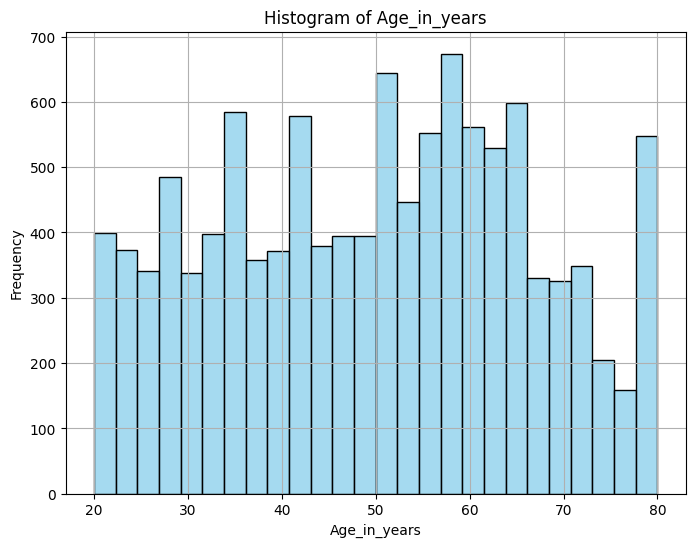

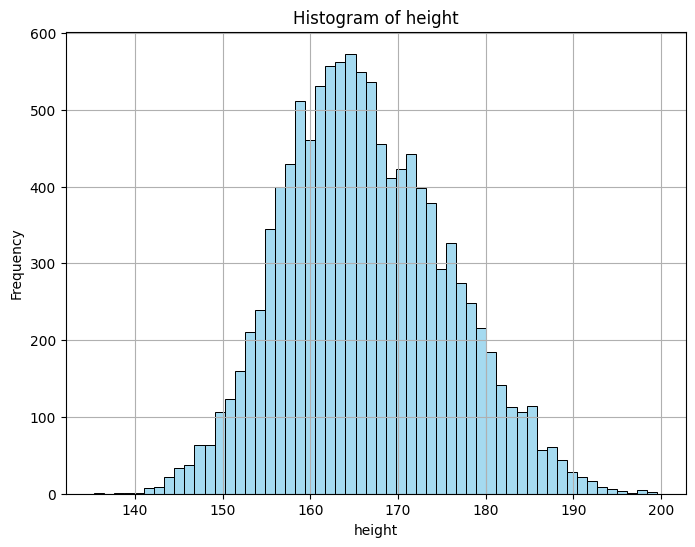

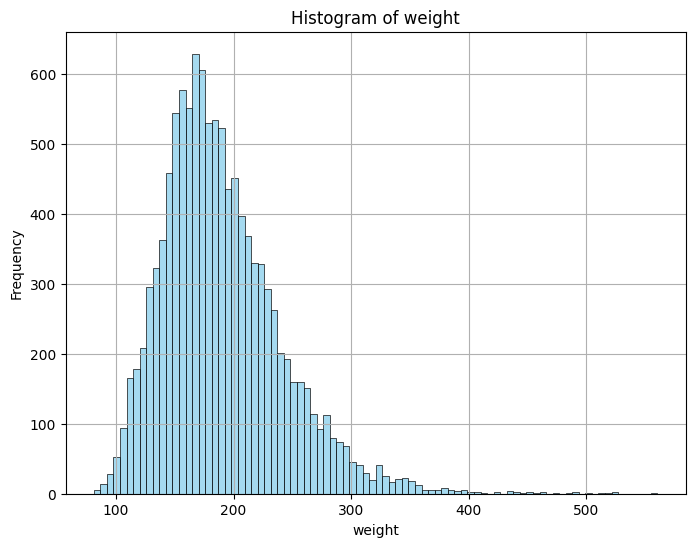

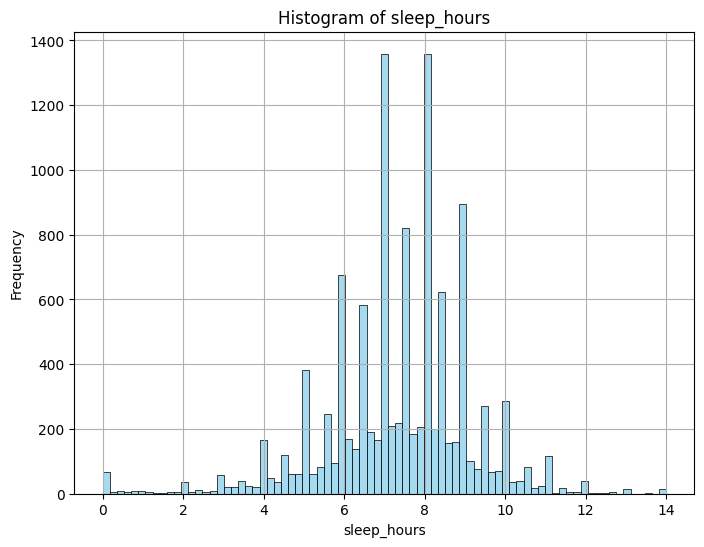

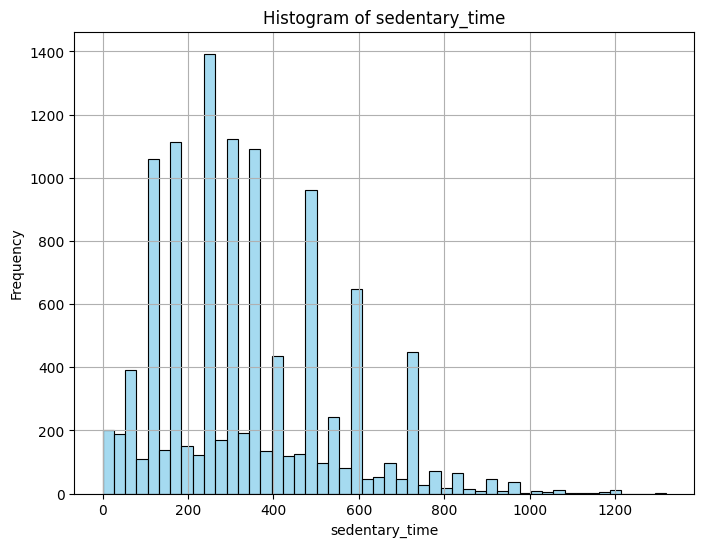

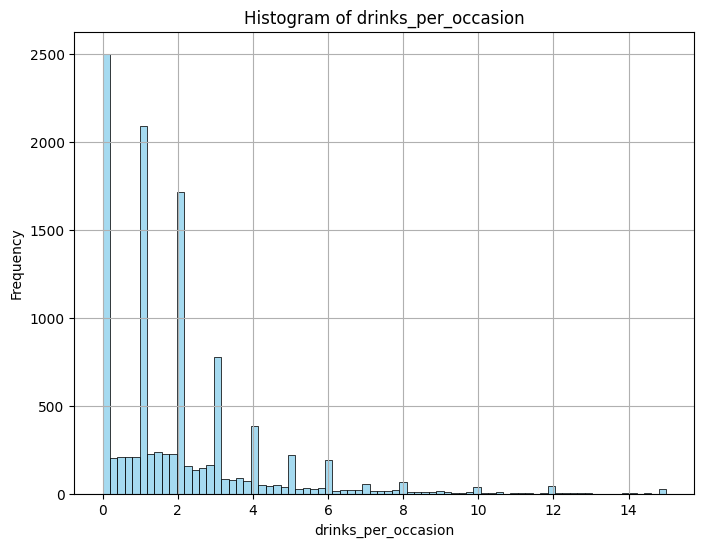

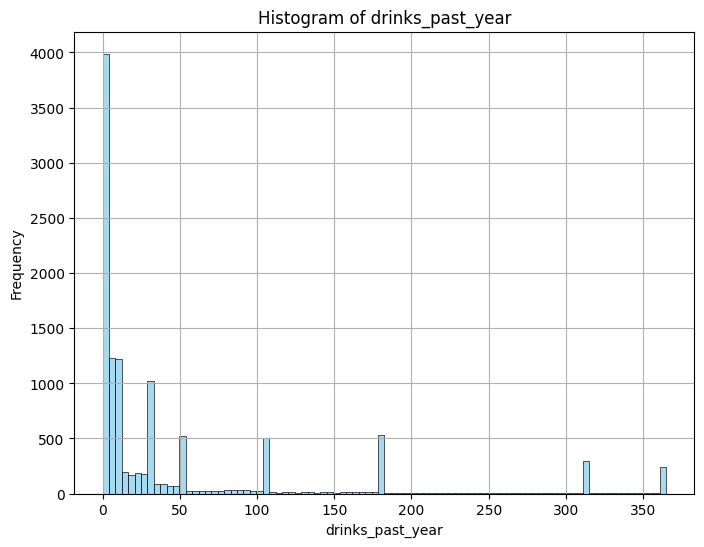

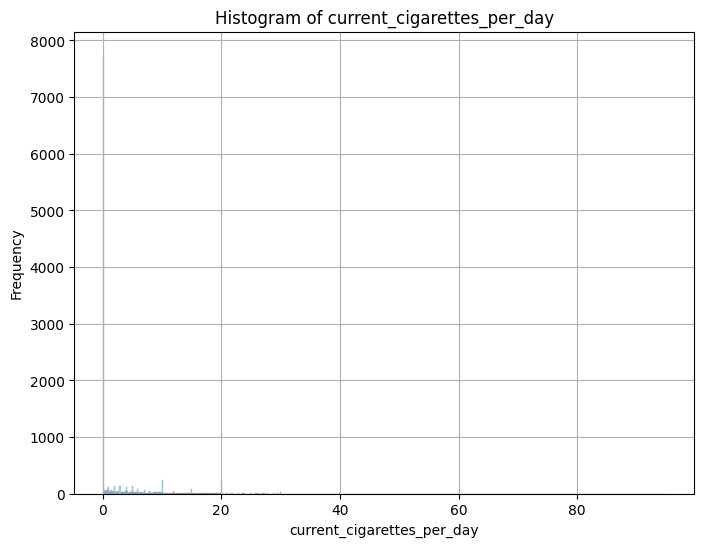

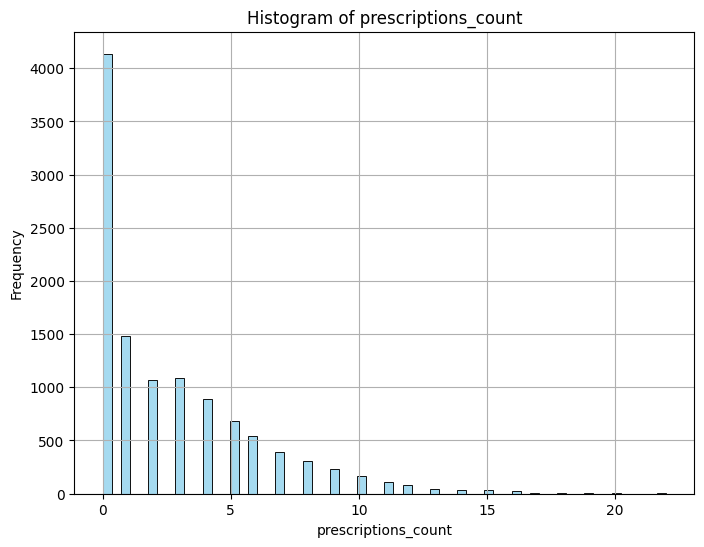

In [6]:
import seaborn as sns
continuous_columns = ['Age_in_years', 'height', 'weight', 'sleep_hours',
        'sedentary_time', 'drinks_per_occasion', 'drinks_past_year', 'current_cigarettes_per_day', 'prescriptions_count']
# Assuming df is your DataFrame and continuous_columns contains the continuous feature names
for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_train[column].dropna(), kde=False, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


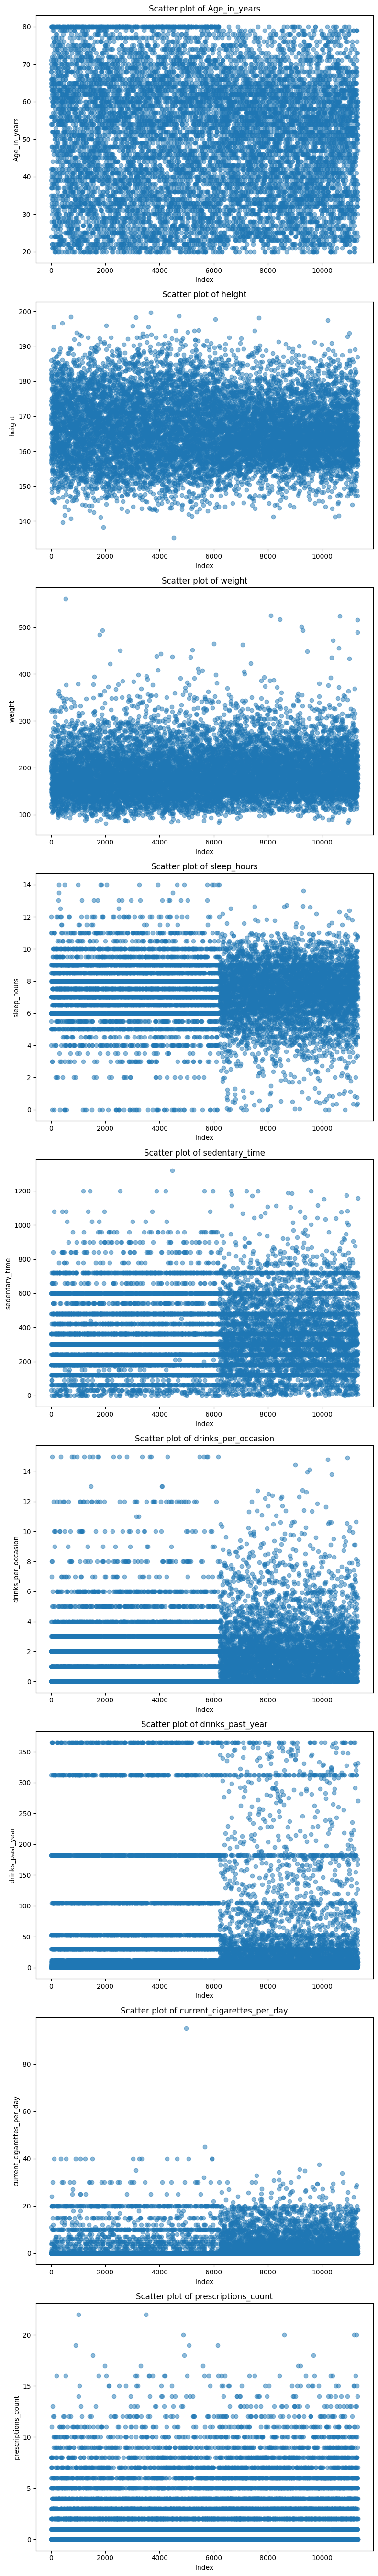

In [7]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and continuous_columns contains the continuous features
continuous_columns = ['Age_in_years', 'height', 'weight', 'sleep_hours',
                      'sedentary_time', 'drinks_per_occasion', 'drinks_past_year',
                      'current_cigarettes_per_day', 'prescriptions_count']

# Set up the figure and axes
num_features = len(continuous_columns)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 6*num_features))

# Iterate through each feature and draw scatter plot
for i, col in enumerate(continuous_columns):
    ax = axes[i]
    ax.scatter(X_train.index, X_train[col], alpha=0.5)
    ax.set_title(f'Scatter plot of {col}')
    ax.set_xlabel('Index')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train_scaled.shape[1]
explained_variance_ratios = []
n_components_range = range(1, n_features + 1)

for n_components in n_components_range:
    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

optimal_n_components = np.argmax(explained_variance_ratios) + 1
print("Optimal number of components:", optimal_n_components)
pca = PCA(n_components=optimal_n_components)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

Optimal number of components: 199


In [9]:
# Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1],
    'solver': ['newton-cg', 'lbfgs'],
    'max_iter': [50, 100, 200, 500]
}

# Initialize the Logistic Regression model with class weight balancing
model = LogisticRegression(class_weight='balanced')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# Predict probabilities on the test data using the best model
probabilities = best_model.predict_proba(X_test)

# Convert probabilities to percentages
percentages = [f"{round(prob[1] * 100, 2)}% depressed, {round(prob[0] * 100, 2)}% not depressed" for prob in probabilities]

# Display the predictions
for i, percentage in enumerate(percentages):
    print(f"Input {i + 1}: {percentage}")

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

yp = best_model.predict(X_train)
print("Classification report of training data")
# Evaluating the model
print(classification_report(y_train, yp))
print("Classification report of test data")
# Classification report with percentages
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures a

Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 50, 'C': 0.1}
Input 1: 27.43% depressed, 72.57% not depressed
Input 2: 37.37% depressed, 62.63% not depressed
Input 3: 39.94% depressed, 60.06% not depressed
Input 4: 5.65% depressed, 94.35% not depressed
Input 5: 22.46% depressed, 77.54% not depressed
Input 6: 65.92% depressed, 34.08% not depressed
Input 7: 16.04% depressed, 83.96% not depressed
Input 8: 29.07% depressed, 70.93% not depressed
Input 9: 36.06% depressed, 63.94% not depressed
Input 10: 2.3% depressed, 97.7% not depressed
Input 11: 5.25% depressed, 94.75% not depressed
Input 12: 13.06% depressed, 86.94% not depressed
Input 13: 23.24% depressed, 76.76% not depressed
Input 14: 89.44% depressed, 10.56% not depressed
Input 15: 59.87% depressed, 40.13% not depressed
Input 16: 23.09% depressed, 76.91% not depressed
Input 17: 76.56% depressed, 23.44% not depressed
Input 18: 8.18% depressed, 91.82% not depressed
Input 19: 6.58% depressed, 93.42% not depres

In [10]:
# Bagging for the best logistic regression
bagging_best_model = BaggingClassifier(base_estimator=best_model, n_estimators=10, random_state=42)
bagging_best_model.fit(X_train, y_train)
bagging_best_model_y_pred = bagging_best_model.predict(X_test)

yp = bagging_best_model.predict(X_train)

# Evaluating the model
print(classification_report(y_train, yp))

print("Bagging for the best model:")
print(classification_report(y_test, bagging_best_model_y_pred))



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5658
           1       0.81      0.83      0.82      5658

    accuracy                           0.81     11316
   macro avg       0.81      0.81      0.81     11316
weighted avg       0.81      0.81      0.81     11316

Bagging for the best model:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1408
           1       0.18      0.44      0.26       147

    accuracy                           0.76      1555
   macro avg       0.56      0.62      0.56      1555
weighted avg       0.86      0.76      0.80      1555



Best Parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best parameters:  {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Training Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5658
           1       0.83      0.81      0.82      5658

    accuracy                           0.82     11316
   macro avg       0.82      0.82      0.82     11316
weighted avg       0.82      0.82      0.82     11316

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1408
           1       0.13      0.31      0.18       147

    accuracy                           0.74      1555
   macro avg       0.52      0.55      0.51      1555
weighted avg       0.84      0.74      0.78      1555



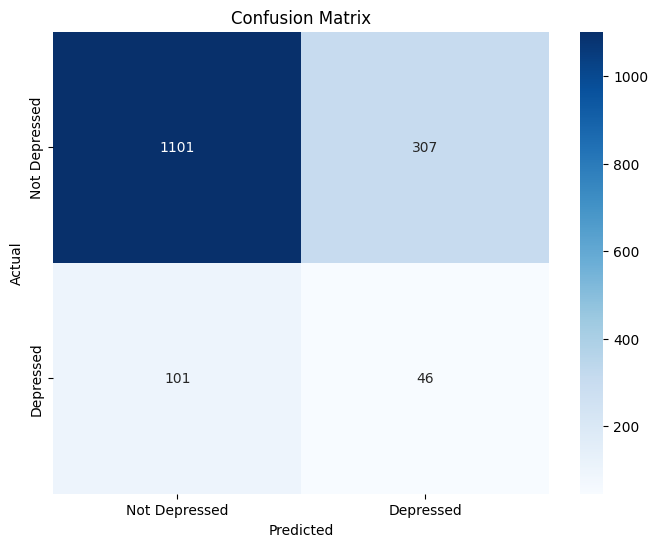

In [13]:
# DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

y_train_pred_proba = best_dt_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.6
y_train_pred = (y_train_pred_proba >= threshold).astype(int)
y_test_pred = (y_test_pred_proba >= threshold).astype(int)
print("Best parameters: ", grid_search.best_params_)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test Accuracy: 0.8
Training Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5658
           1       0.50      1.00      0.67      5658

    accuracy                           0.50     11316
   macro avg       0.25      0.50      0.33     11316
weighted avg       0.25      0.50      0.33     11316

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1408
           1       0.09      1.00      0.17       147

    accuracy                           0.09      1555
   macro avg       0.05      0.50      0.09      1555
weighted avg       0.01      0.09      0.02      1555



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

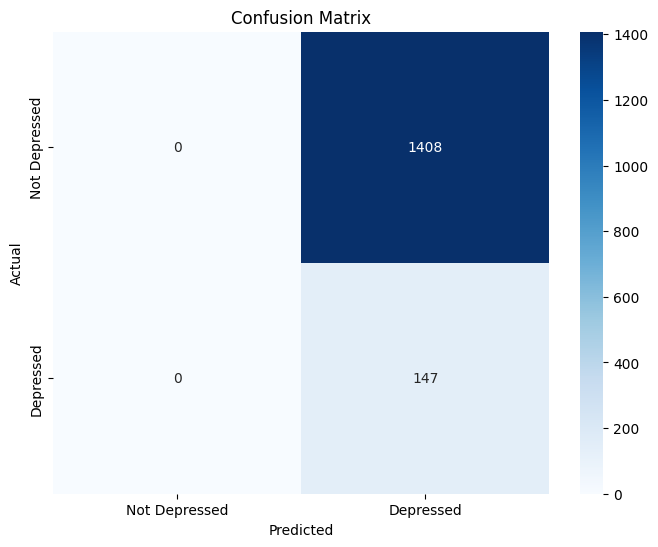

In [14]:
# KNNClassifier
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
             }

random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=80, scoring='accuracy', cv=7, random_state=42)
random_search.fit(X_train, y_train)
knn_model = random_search.best_estimator_

test_accuracy = knn_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

y_train_proba = knn_model.predict_proba(X_train)[:, 1]
y_test_proba = knn_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 100)

best_threshold = None
best_f1_score = 0

for threshold in thresholds:
    y_train_pred = (y_train_proba >= threshold).astype(int)
    y_test_pred = (y_test_proba >= threshold).astype(int)
    train_f1_score = f1_score(y_train, y_train_pred)
    test_f1_score = f1_score(y_test, y_test_pred)
    if test_f1_score > best_f1_score:
        best_threshold = threshold
        best_f1_score = test_f1_score

y_train_pred = (y_train_proba >= best_threshold).astype(int)
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.23536977491961414
Training Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.15      0.24      5658
           1       0.51      0.87      0.64      5658

    accuracy                           0.51     11316
   macro avg       0.53      0.51      0.44     11316
weighted avg       0.53      0.51      0.44     11316

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.19      0.31      1408
           1       0.08      0.68      0.14       147

    accuracy                           0.24      1555
   macro avg       0.47      0.43      0.23      1555
weighted avg       0.78      0.24      0.29      1555



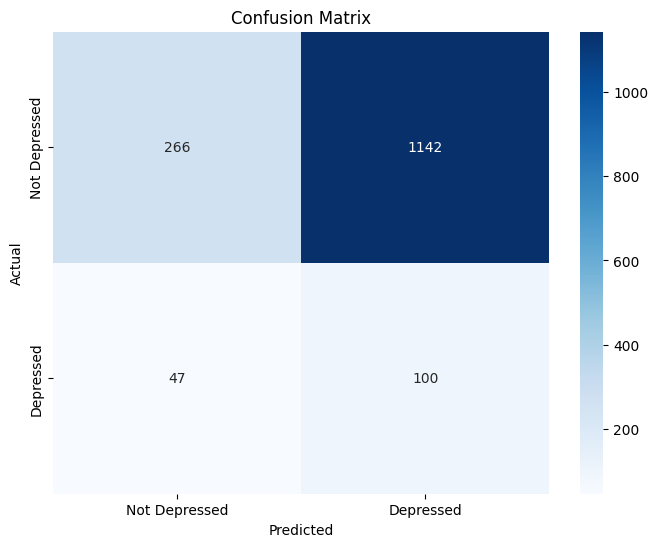

In [16]:
# Gaussian Naive Bayes classifier
nb = GaussianNB()
class_counts = y_train.value_counts()
class_priors = class_counts / len(y_train)
nb.fit(X_train, y_train)

accuracy = nb.score(X_test, y_test)
print("Accuracy:", accuracy)
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# SVC model
svc = SVC(class_weight='balanced', random_state=42)

param_grid = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['linear']
}
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_grid, n_iter=50, cv=5, scoring='f1', random_state=42)
random_search.fit(X_train, y_train)
best_svc = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", random_search.best_score_)

test_accuracy = best_svc.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

y_train_pred = best_svc.predict(X_train)
y_test_pred = best_svc.predict(X_test)

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'C': 0.44388521115218393, 'gamma': 'auto', 'kernel': 'linear'}
Best Score: 0.8029642469013709
Test Accuracy: 0.7620578778135049
Training Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      5658
           1       0.81      0.84      0.82      5658

    accuracy                           0.82     11316
   macro avg       0.82      0.82      0.82     11316
weighted avg       0.82      0.82      0.82     11316

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1408
           1       0.18      0.42      0.25       147

    accuracy                           0.76      1555
   macro avg       0.55      0.61      0.55      1555
weighted avg       0.86      0.76      0.80      1555



In [19]:
# Gradient Boosting Classifier
gboost_base_model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.75, 1.0]
}
random_search = RandomizedSearchCV(estimator=gboost_base_model, param_distributions=param_grid, n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
best_gboost_model = random_search.best_estimator_
gboost_probabilities = best_gboost_model.predict_proba(X_test)

gboost_percentages = [f"{round(prob[1] * 100, 2)}% depressed, {round(prob[0] * 100, 2)}% not depressed" for prob in gboost_probabilities]
for i, percentage in enumerate(gboost_percentages):
    print(f"Input {i + 1}: {percentage}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Input 1: 1.27% depressed, 98.73% not depressed
Input 2: 33.17% depressed, 66.83% not depressed
Input 3: 6.04% depressed, 93.96% not depressed
Input 4: 0.48% depressed, 99.52% not depressed
Input 5: 12.64% depressed, 87.36% not depressed
Input 6: 18.79% depressed, 81.21% not depressed
Input 7: 0.28% depressed, 99.72% not depressed
Input 8: 9.66% depressed, 90.34% not depressed
Input 9: 2.07% depressed, 97.93% not depressed
Input 10: 4.74% depressed, 95.26% not depressed
Input 11: 3.17% depressed, 96.83% not depressed
Input 12: 2.13% depressed, 97.87% not depressed
Input 13: 25.63% depressed, 74.37% not depressed
Input 14: 91.95% depressed, 8.05% not depressed
Input 15: 10.88% depressed, 89.12% not depressed
Input 16: 26.03% depressed, 73.97% not depressed
Input 17: 67.07% depressed, 32.93% not depressed
Input 18: 1.69% depressed, 98.31% not d

In [11]:
#FCNN model
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)

class_weights = dict(enumerate(class_weights))

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12800     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 95426 (372.76 KB)
Trainable params: 95426 

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)
train_predictions = model.predict(X_train)

train_predictions_percentages = train_predictions * 100

train_predicted_labels = np.argmax(train_predictions, axis=1)

train_accuracy = accuracy_score(y_train, train_predicted_labels)
print("Training Accuracy:", train_accuracy)

test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

test_predictions_percentages = test_predictions * 100

fcnn_percentages = [f"{round(test_predictions[1] * 100, 2)}% depressed, {round(test_predictions[0] * 100, 2)}% not depressed" for test_predictions in test_predictions]

for i, percentage in enumerate(fcnn_percentages):
    print(f"Input {i + 1}: {percentage}")

test_predicted_labels = np.argmax(test_predictions, axis=1)

test_accuracy = accuracy_score(y_test, test_predicted_labels)
print("\nTest Accuracy:", test_accuracy)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_predicted_labels))

print("\nTest Classification Report:")
print(classification_report(y_test, test_predicted_labels))

Epoch 1/35
354/354 [==============================] - 4s 5ms/step - loss: 0.6576 - accuracy: 0.6396 - val_loss: 0.6259 - val_accuracy: 0.7254
Epoch 2/35
354/354 [==============================] - 2s 6ms/step - loss: 0.5170 - accuracy: 0.7641 - val_loss: 0.6074 - val_accuracy: 0.7678
Epoch 3/35
354/354 [==============================] - 2s 6ms/step - loss: 0.4386 - accuracy: 0.8051 - val_loss: 0.6191 - val_accuracy: 0.7929
Epoch 4/35
354/354 [==============================] - 1s 4ms/step - loss: 0.4038 - accuracy: 0.8256 - val_loss: 0.6367 - val_accuracy: 0.7595
Epoch 5/35
354/354 [==============================] - 1s 4ms/step - loss: 0.3792 - accuracy: 0.8373 - val_loss: 0.6389 - val_accuracy: 0.7756
Epoch 6/35
354/354 [==============================] - 1s 4ms/step - loss: 0.3581 - accuracy: 0.8477 - val_loss: 0.6625 - val_accuracy: 0.7897
Epoch 7/35
354/354 [==============================] - 1s 4ms/step - loss: 0.3384 - accuracy: 0.8582 - val_loss: 0.6800 - val_accuracy: 0.7717
Epoch 